In [1]:
%matplotlib inline
#%% NumPyの読み込み
import numpy as np
#   NumPyのLinalgモジュールの読み込み
import numpy.linalg as lin
#   CVXPYの読み込み
import cvxpy as cvx
#   Pandasの読み込み
import pandas as pd
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
else:
    print('このPythonコードが対応していないOSを使用しています．')
    sys.exit()
jpfont = FontProperties(fname=FontPath)

In [2]:
#%% 最小分散ポートフォリオの計算
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev) @ CorrMatrix @ np.diag(Stdev)
iota = np.ones(Mu.shape)

In [3]:
print(Sigma)

[[ 25.     12.5     6.75    7.5    13.75 ]
 [ 12.5   100.     27.     30.     22.   ]
 [  6.75   27.     56.25   28.125  29.7  ]
 [  7.5    30.     28.125 225.     74.25 ]
 [ 13.75   22.     29.7    74.25  121.   ]]


In [4]:
inv_Sigma = lin.inv(Sigma)
A = Mu @ inv_Sigma @ iota
B = Mu @ inv_Sigma @ Mu
C = iota @ inv_Sigma @ iota
D = B * C - A ** 2
V_Target = np.linspace(Mu.min(), Mu.max(), num=5)
V_Risk = np.zeros(V_Target.shape)
V_Weight = np.zeros((V_Target.shape[0], Mu.shape[0]))
for idx, Target_Return in enumerate(V_Target):
    V_Weight[idx, :] = (C * Target_Return - A) / D * lin.solve(Sigma, Mu) \
                       + (B - A * Target_Return) / D * lin.solve(Sigma, iota)
    V_Risk[idx] = (C / D) * (Target_Return - A / C) ** 2 + 1.0 / C

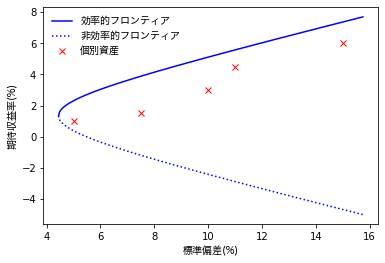

In [5]:
#%% 最小分散フロンティアの作図
sigma_gmv = 1.0 / np.sqrt(C)
sigma_p = np.linspace(sigma_gmv, 1.05 * np.max(Stdev), num=250)
mu_p_efficient = (A + np.sqrt(np.abs(C * sigma_p ** 2 - 1.0) * D)) / C
mu_p_inefficient = (A - np.sqrt(np.abs(C * sigma_p ** 2 - 1.0) * D)) / C
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(sigma_p, mu_p_efficient, 'b-')
plt.plot(sigma_p, mu_p_inefficient, 'b:')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx')
plt.legend(['効率的フロンティア', '非効率的フロンティア', '個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel('標準偏差(%)', fontproperties=jpfont)
plt.ylabel('期待収益率(%)', fontproperties=jpfont)
plt.show()

In [6]:
#%% 空売り制約の下での分散最小化問題の設定
Weight = cvx.Variable(Mu.shape[0])
Target_Return = cvx.Parameter(nonneg=True)
Risk_Variance = cvx.quad_form(Weight, Sigma)
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_Variance),
                            [Weight.T*Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0])

In [7]:
#%% 空売り制約の下での最小分散フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
V_Weight = np.zeros((V_Target.shape[0], Mu.shape[0]))
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cvx.ECOS)
    V_Weight[idx, :] = Weight.value.T
    V_Risk[idx] = np.sqrt(Risk_Variance.value)

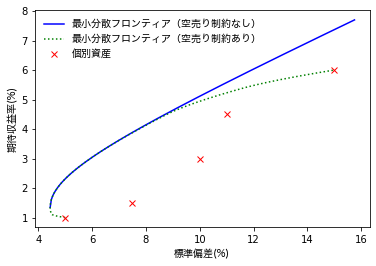

In [8]:
#%% 最小分散フロンティアの作図
sigma_gmv = 1.0 / np.sqrt(C)
sigma_p = np.linspace(sigma_gmv, 1.05 * np.max(Stdev), num=250)
mu_p_efficient = (A + np.sqrt(np.abs(C * sigma_p ** 2 - 1.0) * D)) / C
fig2 = plt.figure(num=2, facecolor='w')
plt.plot(sigma_p, mu_p_efficient, 'b-')
plt.plot(V_Risk, V_Target, 'g:')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx')
plt.legend(['最小分散フロンティア（空売り制約なし）',
            '最小分散フロンティア（空売り制約あり）',
            '個別資産'],
           loc='best',  frameon=False, prop=jpfont)
plt.xlabel('標準偏差(%)', fontproperties=jpfont)
plt.ylabel('期待収益率(%)', fontproperties=jpfont)
plt.show()

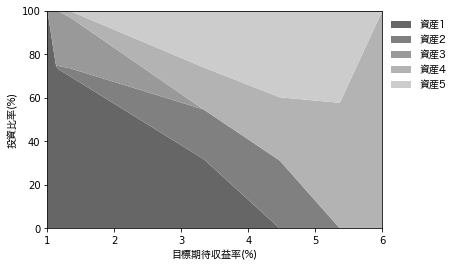

In [9]:
#   投資比率の推移の作図
fig3 = plt.figure(num=3, facecolor='w')
plt.stackplot(V_Target, V_Weight.T*100,
              colors=tuple([tuple(gray*np.ones(3))
                            for gray in np.linspace(0.4, 0.8, num=Mu.shape[0])
                            ]))
plt.axis([Mu.min(), Mu.max(), 0.0, 100.0])
plt.legend(['資産1', '資産2', '資産3', '資産4', '資産5'],
           loc='upper left', bbox_to_anchor=(1.0, 1.0),
           frameon=False, prop=jpfont)
plt.xlabel('目標期待収益率(%)', fontproperties=jpfont)
plt.ylabel('投資比率(%)', fontproperties=jpfont)
plt.show()

In [10]:
#%% 収益率データの読み込み
R = pd.read_csv('asset_return_data.csv', index_col=0)
T = R.shape[0]
N = R.shape[1]
Mu = R.mean().values
Sigma = R.cov().values * ((T - 1.0) / T)
Return_Dev = (R - Mu).values / np.sqrt(T)

In [11]:
#%% 空売り制約の下での分散最小化問題の設定
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
Target_Return = cvx.Parameter(nonneg=True)
Risk_Variance = cvx.sum_squares(Deviation)
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_Variance),
                            [Return_Dev*Weight == Deviation,
                             Weight.T*Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0])

In [12]:
#%% 空売り制約の下での最小分散フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cvx.ECOS)
    V_Risk[idx] = np.sqrt(Risk_Variance.value)

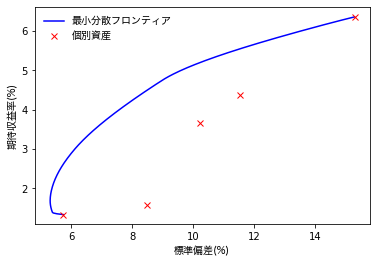

In [13]:
#%% 最小分散フロンティアのグラフの作成
fig4 = plt.figure(num=4, facecolor='w')
plt.plot(V_Risk, V_Target, 'b-')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'rx')
plt.legend(['最小分散フロンティア', '個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel('標準偏差(%)', fontproperties=jpfont)
plt.ylabel('期待収益率(%)', fontproperties=jpfont)
plt.show()